# Kaggle 30 Days of Machine Learning

---

## Introduction

For this competition, you will be predicting a continuous `target` based on a number of feature columns given in the data. All of the feature columns, `cat0` - `cat9` are categorical, and the feature columns `cont0` - `cont13` are continuous.

**Files**
- **train.csv** - the training data with the `target` column
- **test.csv** - the test set; you will be predicting the `target` for each row in this file
- **sample_submission.csv** - a sample submission file in the correct format

---

## Dependencies

In [4]:
# Statistics
import pandas as pd
import numpy as np
import math as mt

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Data Preprocessing - Encoding and Imputation
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Data Preprocessing - Feature Engineering
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA

# Data Preprocessing - ML Pipelines
from sklearn.compose import ColumnTransformer

# ML - Modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# ML - Evaluation
from sklearn.model_selection import cross_val_score

# ML - Tuning
from sklearn.model_selection import GridSearchCV

---

## Import Dataset

In [5]:
import os
kaggle_project = '30-days-of-ml'
# Import dataset from local directory './data' or from Kaggle
data_dir = ('./data' if os.path.exists('data') else f'/kaggle/input/{kaggle_project}')

# print all files in data_dir
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/test.csv
./data/train.csv
./data/sample_submission.csv
./data/.ipynb_checkpoints/sample_submission-checkpoint.csv


In [6]:
train_data = pd.read_csv(f'{data_dir}/train.csv')
test_data = pd.read_csv(f'{data_dir}/test.csv')

# Drop id from train_data
train_data.drop(columns='id', inplace=True)
train_data.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,B,B,B,C,B,B,A,E,C,N,...,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634
1,B,B,A,A,B,D,A,F,A,O,...,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233
2,A,A,A,C,B,D,A,D,A,F,...,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351
3,B,B,A,C,B,D,A,E,C,K,...,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253
4,A,A,A,C,B,D,A,E,A,N,...,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260


---

### Split Dataset into train and validation

In [7]:
X = train_data.copy()
y = X.pop("target")

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)

---

## EDA

---

### Missing Values

Since the train dataset does not have any missing value, there is not necessary for data imputation.

In [8]:
# print missing values from train_data and test_data
train_data.isna().sum().sum(), test_data.isna().sum().sum()

(0, 0)

---

### Target Distribution

99.82% target data is located in 6.5 to 10.5.

Text(0.5, 1.0, 'Distribution of All Targets')

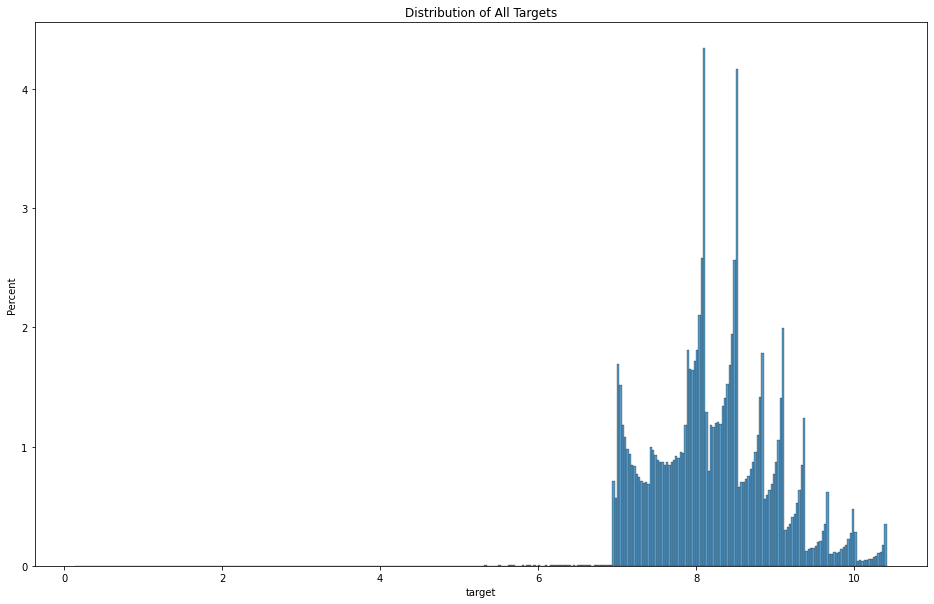

In [34]:
plt.figure(figsize=(16, 10))
sns.histplot(x=y, stat='percent')
plt.title('Distribution of All Targets')

In [16]:
len(y[(6.5 <= y) & (y < 10.5)]) / len(y)

0.9982266666666667

---

### Numerical Data

Since all of the numerical data are in the same scale, there is no need for scaling.

In [8]:
train_data.describe()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.527335,0.460926,0.490498,0.496689,0.491654,0.510526,0.467476,0.537119,0.498456,0.474872,0.474492,0.473216,0.494561,0.508273,8.241979
std,0.230599,0.214003,0.253346,0.219199,0.240074,0.228232,0.210331,0.218140,0.239920,0.218007,0.255949,0.222022,0.247292,0.222950,0.746555
min,-0.118039,-0.069309,-0.056104,0.130676,0.255908,0.045915,-0.224689,0.203763,-0.260275,0.117896,0.048732,0.052608,-0.074208,0.151050,0.140329
25%,0.405965,0.310494,0.300604,0.329783,0.284188,0.354141,0.342873,0.355825,0.332486,0.306874,0.276017,0.308151,0.289074,0.300669,7.742071
50%,0.497053,0.427903,0.502462,0.465026,0.390470,0.488865,0.429383,0.504661,0.439151,0.434620,0.459975,0.433812,0.422887,0.472400,8.191373
75%,0.668060,0.615113,0.647512,0.664451,0.696599,0.669625,0.573383,0.703441,0.606056,0.614333,0.691579,0.642057,0.714502,0.758447,8.728634
max,1.058443,0.887253,1.034704,1.039560,1.055424,1.067649,1.111552,1.032837,1.040229,0.982922,1.055960,1.071444,0.975035,0.905992,10.411992


In [53]:
# Define Numercial Columns
num_cols = X.select_dtypes(include=['float']).columns
num_cols

Index(['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7',
       'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13'],
      dtype='object')

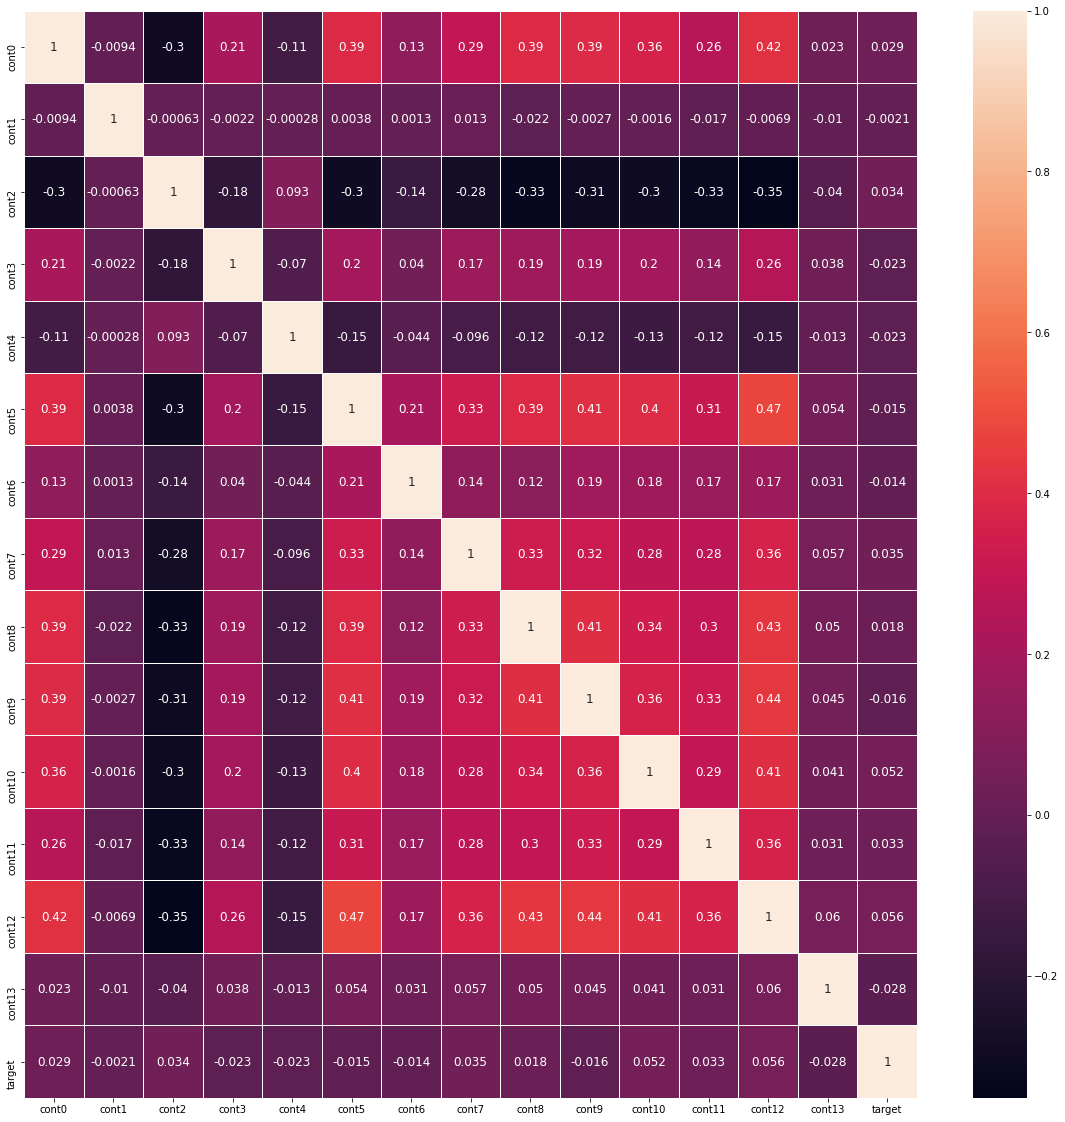

In [11]:
plt.figure(figsize = (20, 20))
#sns.heatmap(train_data.corr(), annot=True);
ax = sns.heatmap(train_data.corr(), annot=True, annot_kws={'size': 12}, linewidths=.5)

In [12]:
print("Correlation with target:\n")
pd.DataFrame(X.corrwith(y), columns=['Correlation Coefficient']).style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

Correlation with target:



,Correlation Coefficient
cont0,0.028819
cont1,-0.002096
cont2,0.034280
cont3,-0.022759
cont4,-0.023132
cont5,-0.015058
cont6,-0.013807
cont7,0.035143
cont8,0.017740
cont9,-0.015726


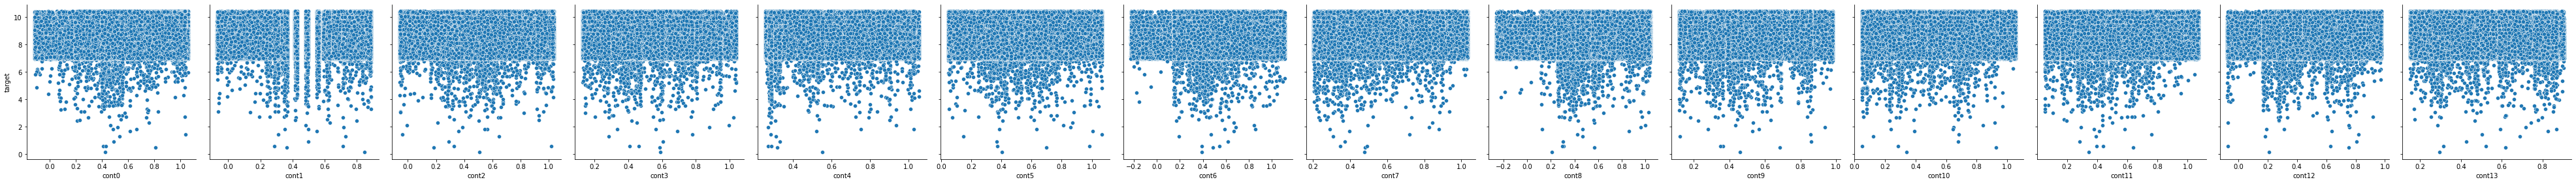

In [54]:
#g = sns.PairGrid(train_data, x_vars=['cont0', 'cont1'], y_vars=['target'], height=4)
g = sns.PairGrid(train_data, x_vars=num_cols, y_vars=['target'], height=4)
g.map(sns.scatterplot)

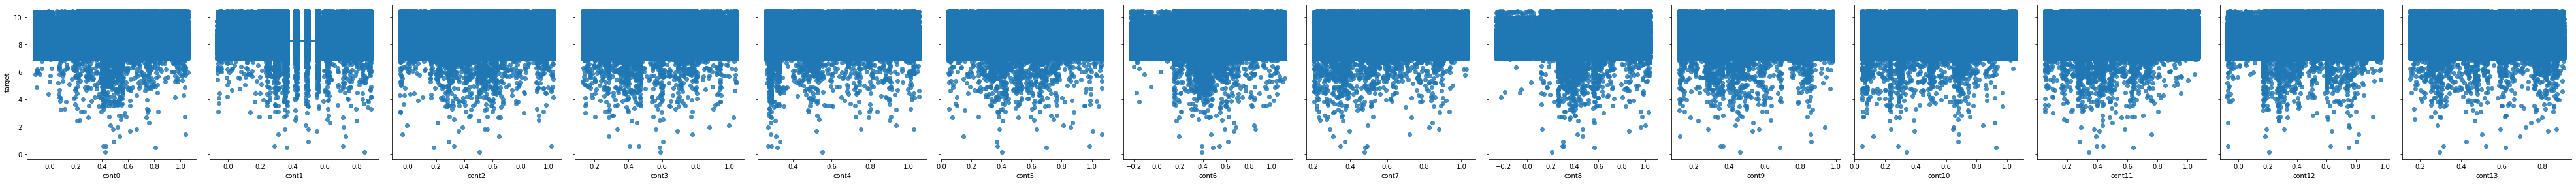

In [68]:
#g = sns.PairGrid(train_data, x_vars=['cont0', 'cont1'], y_vars=['target'], height=4)
g = sns.PairGrid(train_data, x_vars=num_cols, y_vars=['target'], height=4)
g.map(sns.regplot)

In [ ]:
features = ["YearBuilt", "MoSold", "ScreenPorch"]
sns.relplot(
    x="value", y="target", col="variable", data=df.melt(id_vars="SalePrice", value_vars=features), facet_kws=dict(sharex=False),
);

---

### Categorical Data

I will implement cross validation for `k=5`.</br>
Therefore, to check if the dataset imbalanced, the minimum unique data for each catogrical should be at least 5.

In [43]:
# Define Categorical Columns
cat_cols = X.select_dtypes(include=['object']).columns
cat_cols

Index(['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9'],
      dtype='object')

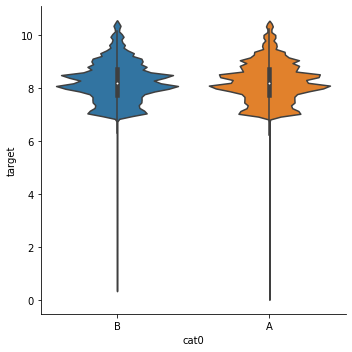

In [71]:
sns.catplot(x='cat0', y='target', data=train_data, kind='violin')

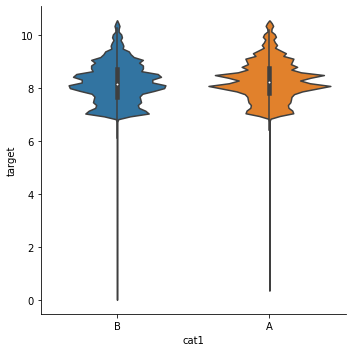

In [72]:
sns.catplot(x='cat1', y='target', data=train_data, kind='violin')

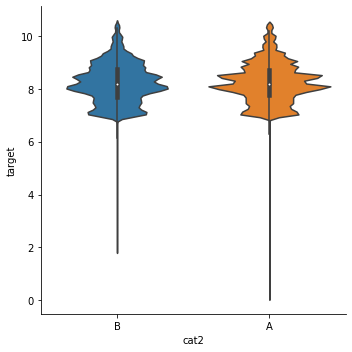

In [73]:
sns.catplot(x='cat2', y='target', data=train_data, kind='violin')

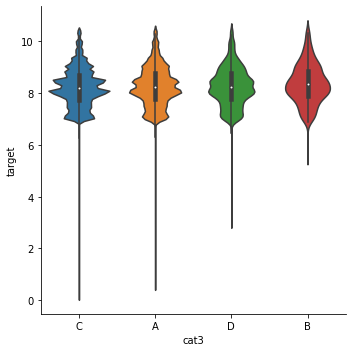

In [74]:
sns.catplot(x='cat3', y='target', data=train_data, kind='violin')

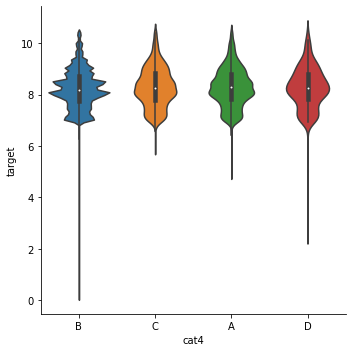

In [75]:
sns.catplot(x='cat4', y='target', data=train_data, kind='violin')

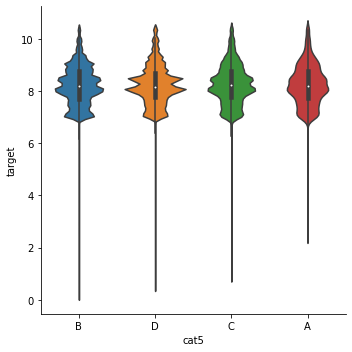

In [76]:
sns.catplot(x='cat5', y='target', data=train_data, kind='violin')

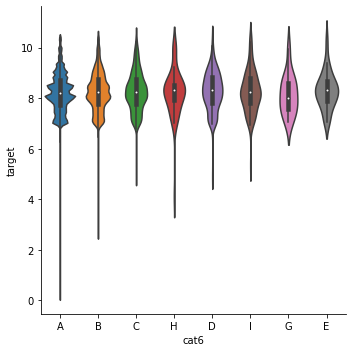

In [77]:
sns.catplot(x='cat6', y='target', data=train_data, kind='violin')

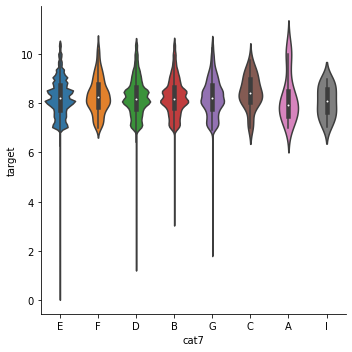

In [78]:
sns.catplot(x='cat7', y='target', data=train_data, kind='violin')

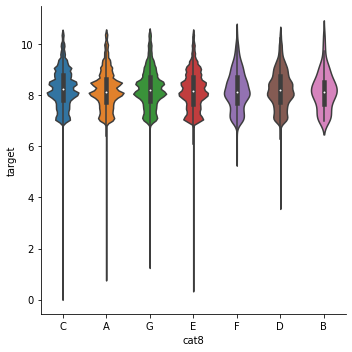

In [79]:
sns.catplot(x='cat8', y='target', data=train_data, kind='violin')

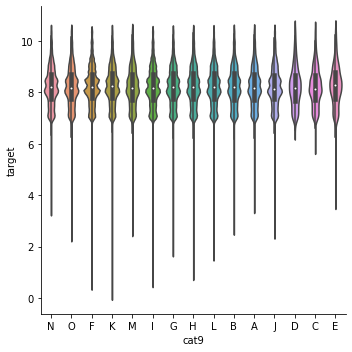

In [80]:
sns.catplot(x='cat9', y='target', data=train_data, kind='violin')

---

### Outliers

In [ ]:
sns

In [ ]:
# Tukey Rule
def outliers(data):
    Q3 = data.quantile

---

## Feature Selection

The Goals of feature engineering:
- improve a model's predictive performance
- reduce computational or data needs
- improve interpretability of the results

The possible ways of feature engineering:
- Creating new features
- K-means clustering
- Pinciple Component Analysis

Metric of feature engineering:
- Mutual Information

---

### Mutual Information

In [14]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [15]:
%%time

X = train_data.copy()
y = X.pop("target")

# Review the MI score from the raw numerical data
num_mi_scores = pd.DataFrame(make_mi_scores(X[num_cols], y))

num_mi_scores.style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

CPU times: user 44.9 s, sys: 305 ms, total: 45.2 s
Wall time: 45.3 s


,MI Scores
cont12,0.021699
cont10,0.018486
cont9,0.012104
cont2,0.009703
cont7,0.009526
cont4,0.008801
cont8,0.008054
cont0,0.007357
cont6,0.005716
cont11,0.005455


In [16]:
%%time

X = train_data.copy()
y = X.pop("target")

# Review the MI score from all data
all_mi_scores = pd.DataFrame(make_mi_scores(X, y))

all_mi_scores.style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

CPU times: user 1min 12s, sys: 708 ms, total: 1min 13s
Wall time: 1min 13s


,MI Scores
cont12,0.021699
cont10,0.018486
cont9,0.012104
cont2,0.009703
cont7,0.009526
cont4,0.008801
cont8,0.008054
cat5,0.007753
cont0,0.007357
cat8,0.006478


---

### PCA

In [18]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [19]:
print("Correlation with target:\n")
pd.DataFrame(X.corrwith(y), columns=['Correlation Coefficient']).style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

Correlation with target:



,Correlation Coefficient
cont0,0.028819
cont1,-0.002096
cont2,0.034280
cont3,-0.022759
cont4,-0.023132
cont5,-0.015058
cont6,-0.013807
cont7,0.035143
cont8,0.017740
cont9,-0.015726


In [20]:
X = train_data.copy()
y = X.pop("target")

# `apply_pca`, defined above, reproduces the code from the tutorial
pca, X_pca, loadings = apply_pca(X[num_cols])
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
cont0,0.320756,-0.027222,-0.098692,-0.079434,0.106768,-0.022713,-0.366510,-0.128103,-0.205264,-0.132746,-0.766627,-0.152704,0.207963,0.060252
cont1,-0.004649,-0.804496,0.544932,-0.213673,0.019404,-0.041700,0.003115,-0.060300,0.023441,-0.044048,0.001646,0.009878,0.042275,-0.004314
cont2,-0.286570,0.010638,-0.001972,-0.025367,-0.103115,0.145721,-0.533295,0.274796,0.682933,-0.086016,-0.057699,0.075802,0.203150,-0.034527
cont3,0.188902,0.049786,-0.083171,-0.511279,0.194789,0.756961,0.231668,0.056232,0.063090,-0.092050,0.032648,0.050959,0.041513,0.088935
cont4,-0.121860,0.077264,0.157689,0.220669,0.940827,-0.031681,-0.056052,-0.052671,0.095268,0.037297,0.044139,-0.033132,-0.002889,-0.004865
cont5,0.344365,-0.026545,0.023829,0.052768,-0.037805,0.033088,-0.263420,-0.013748,0.137442,0.110437,0.302107,-0.629485,-0.234660,0.481228
cont6,0.156336,-0.026164,0.289700,0.727718,-0.151245,0.513417,-0.009177,0.109351,-0.154722,-0.122380,-0.009466,0.045713,0.138425,-0.051028
cont7,0.286408,-0.014699,0.070223,-0.032855,0.088370,-0.184481,0.146834,0.869181,-0.038456,0.254040,-0.137757,0.072864,-0.034960,0.036626
cont8,0.329196,0.031584,-0.069116,-0.077735,0.072348,-0.229584,-0.164251,0.039166,-0.150465,-0.359585,0.471047,0.225594,0.594074,0.125357
cont9,0.337600,-0.017870,-0.010082,0.048760,0.037573,-0.064434,-0.177653,-0.047571,0.135664,-0.387481,-0.003510,0.497452,-0.652441,0.046299


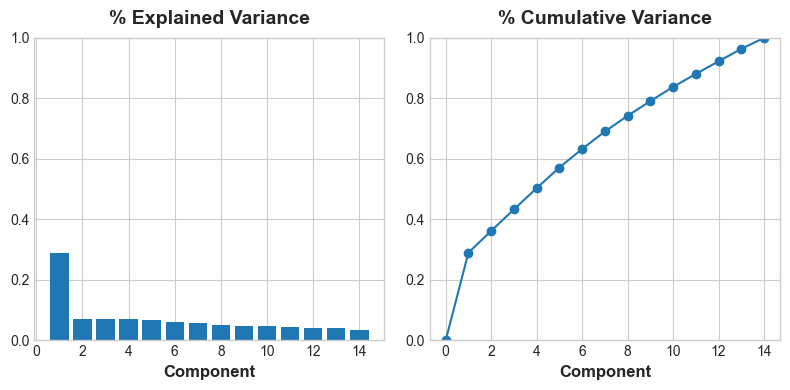

In [21]:
plot_variance(pca);

In [22]:
%%time
pca_mi_scores = pd.DataFrame(make_mi_scores(X_pca, y))
#pca_mi_scores = pd.DataFrame(mi_scores).style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

pca_mi_scores.style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

CPU times: user 46.9 s, sys: 399 ms, total: 47.3 s
Wall time: 47.6 s


,MI Scores
PC1,0.008565
PC14,0.005343
PC10,0.003831
PC13,0.003422
PC12,0.003352
PC6,0.003082
PC8,0.001847
PC11,0.001577
PC9,0.001228
PC4,0.000923


In [23]:
def test_pca(model, X):
    # Test PCA numberical data first
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                    random_state=0)

    # Fit the model
    model.fit(X_train, y_train)

    # Prediction
    pred = model.predict(X_valid)

    # Calculate RMSE
    return mt.sqrt(mean_squared_error(y_valid, pred))

In [24]:
# Model hyperparameters
xgb_params = {'n_estimators': 1000,
              'learning_rate': 0.1,
              #'subsample': 0.8,
              'colsample_bytree': 0.3,
              'max_depth': 3,
              'booster': 'gbtree', 
              #'reg_lambda': 45.1,
              #'reg_alpha': 34.9,
              'random_state': 0,
              'n_jobs': 4}

model = XGBRegressor(**xgb_params, tree_method = 'gpu_hist')

In [25]:
%%time

X = train_data.copy()
y = X.pop("target")

# numerical data only
# 0.7276467952234649
# 0.7228196639975967
#test_pca(model, X[num_cols])

# pca only
# 0.7456365639105215
# 0.7409662927889535
#test_pca(model, X_pca)

# pac (no 0 pc)
# 0.744166905080158
# 0.7413420081098745
#test_pca(model, X_pca[pca_mi_scores.iloc[0:12, :].index])

# numerical data + pca
# 0.727961200766366
# 0.7235085989402649
test_pca(model, X[num_cols].join(X_pca))

# numerical data + pca (no 0 pc)
# 0.7281481337015027
# 0.7234893735995077
# test_pca(model, X[num_cols].join(X_pca[pca_mi_scores.iloc[0:12, :].index]))

NameError: name 'train_test_split' is not defined

---

### K-means Clustering

'LotArea', 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF', 'GrLivArea'


OverallQual     0.581262<br>
Neighborhood    0.569813<br>
**GrLivArea**       0.496909<br>
YearBuilt       0.437939<br>
GarageArea      0.415014<br>
**TotalBsmtSF**     0.390280<br>
GarageCars      0.381467<br>
**FirstFlrSF**      0.368825<br>
BsmtQual        0.364779<br>
KitchenQual     0.326194

---

## Data Engineering

---

### Data Pipline

In [27]:
X = train_data.copy()
y = X.pop("target")

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
cat_cols_nunique = X[cat_cols].nunique()
onehot_cols = cat_cols_nunique[cat_cols_nunique < 10].keys()
ordinal_cols = cat_cols_nunique[cat_cols_nunique >= 10].keys()

# Keep selected columns only
# my_cols = list(num_cols) + list(onehot_cols)

assert len(num_cols)  + len(onehot_cols) + len(ordinal_cols) == X.shape[1], 'feature selection error'

In [28]:
def pipeline_test(model, num_cols, onehot_cols, ordinal_cols):
    my_cols = list(num_cols) + list(onehot_cols) + list(ordinal_cols)
    
    X = train_data.copy()
    y = X.pop(target_col)

    # Break off validation set from training data
    X_train, X_valid, y_train, y_valid = train_test_split(X[my_cols], y, 
                                                          train_size=0.8, test_size=0.2,
                                                          random_state=0)
    
    # Preprocessing for numerical data
    numerical_transformer = SimpleImputer(strategy='median')

    # Preprocessing of One Hot Encoding
    onehot_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Preprocessing of Ordnial Encoding
    ordinal_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder())
    ])

    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, num_cols),
            ('onehot', onehot_transformer, onehot_cols),
            ('ordinal', ordinal_transformer, ordinal_cols)
        ])

    '''
    # Define model
    model = XGBRegressor(random_state=0, 
                       n_estimators=n_estimators, 
                       learning_rate=learning_rate, 
                       #early_stopping_rounds=5, 
                       n_jobs=8)
    '''
    
    # Bundle preprocessing and modeling code in a pipeline
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])

    # Preprocessing of training data, fit model 
    clf.fit(X_train, y_train)

    # Preprocessing of validation data, get predictions
    preds = clf.predict(X_valid)

    return mt.sqrt(mean_squared_error(y_valid, preds))

In [29]:
%%time

# All features
# 0.7260505155612701
pipeline_test(num_cols, onehot_cols, ordinal_cols)

TypeError: pipeline_test() missing 1 required positional argument: 'ordinal_cols'

In [30]:
all_mi_scores.style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

,MI Scores
cont12,0.021699
cont10,0.018486
cont9,0.012104
cont2,0.009703
cont7,0.009526
cont4,0.008801
cont8,0.008054
cat5,0.007753
cont0,0.007357
cat8,0.006478


In [31]:
%%time

# Old 
# Features with high MI scores
# remove cat2, cat6, cat4, cat3, cat7
# 0.726241483801544
qualified_onehot_cols = list(set(all_mi_scores.index[:19]) - set(ordinal_cols) - set(num_cols))
pipeline_test(num_cols=num_cols, onehot_cols=qualified_onehot_cols, ordinal_cols=ordinal_cols)

# remove cat2
# 0.7258199381035028
#qualified_onehot_cols = list(set(onehot_cols) - {'cat2'})
#pipeline_test(num_cols=num_cols, onehot_cols=qualified_onehot_cols, ordinal_cols=ordinal_cols)

# remove cat2, cat6
# 0.726366300396063
#qualified_onehot_cols = list(set(onehot_cols) - {'cat2', 'cat6'})
#pipeline_test(num_cols=num_cols, onehot_cols=qualified_onehot_cols, ordinal_cols=ordinal_cols)

TypeError: pipeline_test() missing 1 required positional argument: 'model'

In [32]:
%%time


# Old
# Change Learning Rate
qualified_onehot_cols = list(set(onehot_cols) - {'cat2'})

# n_estimators=250, learning_rate=0.1
# 0.7232377517519889
#pipeline_test(num_cols=num_cols, onehot_cols=qualified_onehot_cols, ordinal_cols=ordinal_cols, n_estimators=250, learning_rate=0.1)

# n_estimators=250, learning_rate=0.2
# 0.7257177726569698
#pipeline_test(num_cols=num_cols, onehot_cols=qualified_onehot_cols, ordinal_cols=ordinal_cols, n_estimators=250, learning_rate=0.2)

CPU times: user 18 µs, sys: 1e+03 ns, total: 19 µs
Wall time: 21 µs


In [33]:
# Model hyperparameters
xgb_params = {'n_estimators': 1000,
              'learning_rate': 0.1,
              #'subsample': 0.8,
              'colsample_bytree': 0.3,
              'max_depth': 3,
              'booster': 'gbtree', 
              #'reg_lambda': 45.1,
              #'reg_alpha': 34.9,
              'random_state': 0,
              'n_jobs': 4}

model = XGBRegressor(**xgb_params, tree_method = 'gpu_hist')

In [34]:
%%time
qualified_onehot_cols = list(set(onehot_cols) - {'cat2'})

# 0.7232377517519889
# 0.7298
# 0.7233668646163762
# 0.7262593666191223
# 0.7283097345052583
# 0.7227767321683206 250, 0.3, 3
# 0.7222954361113229 250, 0.3, 4
# 0.721261321117992
# 0.7212368787368652
pipeline_test(model, num_cols=num_cols, onehot_cols=qualified_onehot_cols, ordinal_cols=ordinal_cols)

XGBoostError: [13:08:09] /Users/travis/build/dmlc/xgboost/src/gbm/../common/common.h:157: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000168ea5de4 dmlc::LogMessageFatal::~LogMessageFatal() + 116
  [bt] (1) 2   libxgboost.dylib                    0x0000000168f3d742 xgboost::gbm::GBTree::ConfigureUpdaters() + 514
  [bt] (2) 3   libxgboost.dylib                    0x0000000168f3d1a5 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > >, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > > > > const&) + 1141
  [bt] (3) 4   libxgboost.dylib                    0x0000000168f5764b xgboost::LearnerConfiguration::Configure() + 1499
  [bt] (4) 5   libxgboost.dylib                    0x0000000168f57a88 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 120
  [bt] (5) 6   libxgboost.dylib                    0x0000000168e9ca49 XGBoosterUpdateOneIter + 137
  [bt] (6) 7   libffi.dylib                        0x00007fff2db178f5 ffi_call_unix64 + 85
  [bt] (7) 8   ???                                 0x00007ffeefa639b0 0x0 + 140732919069104



---

## Auto Tuning

In [ ]:
def auto_tuning(model, num_cols, onehot_cols, ordinal_cols):
    my_cols = list(num_cols) + list(onehot_cols) + list(ordinal_cols)
    
    X = train_data.copy()
    y = X.pop(target_col)

    # Break off validation set from training data
    X_train, X_valid, y_train, y_valid = train_test_split(X[my_cols], y, 
                                                          train_size=0.8, test_size=0.2,
                                                          random_state=0)
    
    # Preprocessing for numerical data
    numerical_transformer = SimpleImputer(strategy='median')

    # Preprocessing of One Hot Encoding
    onehot_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Preprocessing of Ordnial Encoding
    ordinal_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder())
    ])

    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, num_cols),
            ('onehot', onehot_transformer, onehot_cols),
            ('ordinal', ordinal_transformer, ordinal_cols)
        ])

    '''
    # Define model
    model = XGBRegressor(random_state=0, 
                       n_estimators=n_estimators, 
                       learning_rate=learning_rate, 
                       #early_stopping_rounds=5, 
                       n_jobs=8)
    '''
    
    # Bundle preprocessing and modeling code in a pipeline
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])

    clf = GridSearchCV(estimator=xgb, 
                       param_grid=params,
                       scoring='neg_mean_squared_error', 
                       verbose=1)
    
    # Preprocessing of training data, fit model 
    clf.fit(X_train, y_train)

    # Preprocessing of validation data, get predictions
    preds = clf.predict(X_valid)

    return mt.sqrt(mean_squared_error(y_valid, preds))

In [ ]:
X = train_data.copy()
y = X.pop(target_col)

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X.drop(columns=['cat2']), y, 
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [ ]:
# Use as many lines of code as you need!
one_hot_cols = list(onehot_cols)
one_hot_cols.remove('cat2')

onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_X_train = pd.DataFrame(onehot_encoder.fit_transform(X_train[one_hot_cols]))
OH_X_valid = pd.DataFrame(onehot_encoder.transform(X_valid[one_hot_cols]))

OH_X_train.index = X_train[one_hot_cols].index
OH_X_valid.index = X_valid[one_hot_cols].index

OH_X_train = pd.concat([OH_X_train, X_train[num_cols]], axis=1)
OH_X_valid = pd.concat([OH_X_valid, X_valid[num_cols]], axis=1)

In [ ]:
ordinal_encoder = OrdinalEncoder()

X_train[ordinal_cols] = ordinal_encoder.fit_transform(X_train[ordinal_cols])
X_valid[ordinal_cols] = ordinal_encoder.transform(X_valid[ordinal_cols])

In [ ]:
X_train = pd.concat([X_train[ordinal_cols], OH_X_train], axis=1)
X_valid = pd.concat([X_valid[ordinal_cols], OH_X_train], axis=1)

In [ ]:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
           'n_estimators': [100, 250, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}

clf = GridSearchCV(estimator=XGBRegressor(seed = 0, tree_method='gpu_hist'), 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(X_train, y_train)

In [ ]:
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

In [ ]:
# No One Hot Encoding
def pipeline_test_onehot(model, num_cols, onehot_cols, ordinal_cols):
    # Sequence must be same
    cat_cols = list(onehot_cols) + list(ordinal_cols)
    cat_cols.sort()
    my_cols = cat_cols + list(num_cols)
    
    X = train_data.copy()
    y = X.pop(target_col)

    # Break off validation set from training data
    X_train, X_valid, y_train, y_valid = train_test_split(X[my_cols], y, 
                                                          train_size=0.8, test_size=0.2,
                                                          random_state=0)
    
    # Preprocessing for numerical data
    numerical_transformer = SimpleImputer(strategy='median')

    # Preprocessing of One Hot Encoding
    onehot_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Preprocessing of Ordnial Encoding
    ordinal_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder())
    ])

    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, num_cols),
            #('onehot', onehot_transformer, onehot_cols),
            ('ordinal', ordinal_transformer, cat_cols)
        ])

    # Bundle preprocessing and modeling code in a pipeline
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])

    # Preprocessing of training data, fit model 
    clf.fit(X_train, y_train)

    # Preprocessing of validation data, get predictions
    preds = clf.predict(X_valid)

    return mt.sqrt(mean_squared_error(y_valid, preds))

In [ ]:
# Model hyperparameters
xgb_params = {'n_estimators': 1000,
              'learning_rate': 0.1,
              #'subsample': 0.8,
              'colsample_bytree': 0.3,
              'max_depth': 3,
              #'booster': 'gbtree', 
              #'reg_lambda': 45.1,
              #'reg_alpha': 34.9,
              'random_state': 0,
              'n_jobs': 4}

model = XGBRegressor(**xgb_params, tree_method = 'gpu_hist')

In [ ]:
%%time

# All features
# 0.7261989358299616
# 0.7213641876288879
pipeline_test_onehot(model, num_cols, onehot_cols, ordinal_cols)

In [ ]:
%%time

# Features with high MI scores
# remove cat2, cat6, cat4, cat3, cat7
# 0.7252062667482022
# 0.7211544652890359
#qualified_onehot_cols = list(set(onehot_cols) - {'cat2', 'cat6', 'cat4', 'cat3', 'cat7'})
#pipeline_test_onehot(model, num_cols=num_cols, onehot_cols=qualified_onehot_cols, ordinal_cols=ordinal_cols)

# remove cat2
# 0.7259727614968562
# 0.7213307169770751
#qualified_onehot_cols = list(set(onehot_cols) - {'cat2'})
#pipeline_test_onehot(model, num_cols=num_cols, onehot_cols=qualified_onehot_cols, ordinal_cols=ordinal_cols)

# remove cat2, cat6
# 0.7253741319413848
# 0.7212668210822997
qualified_onehot_cols = list(set(onehot_cols) - {'cat2', 'cat6'})
pipeline_test_onehot(model, num_cols=num_cols, onehot_cols=qualified_onehot_cols, ordinal_cols=ordinal_cols)

---

## Modeling

### Training

In [ ]:
def get_score(n_estimators):
    """Return the average MAE over 5 CV folds of random forest model.
    
    Keyword argument:
    n_estimators -- the number of trees in the forest
    """
    # Define the model
    xgb = XGBRegressor(random_state=0, 
                       n_estimators=n_estimators, 
                       learning_rate=0.1, 
                       #early_stopping_rounds=5, 
                       n_jobs=8)

    # Define pipline
    my_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', xgb)
    ])
    # Define cross-validation
    scores = -1 * cross_val_score(my_pipeline, X, y,
                                  cv=5,
                                  scoring='neg_mean_squared_error')

    
    return scores.mean()

In [ ]:
results = {n_estimators: get_score(n_estimators) for n_estimators in range(50, 501, 50)}
print(results)

In [ ]:
plt.plot(list(results.keys()), list(results.values()))
plt.show()

---

### Evaluation

One Time Evaluation:
- Raw numerical data only: 0.5291350082190278
- PCA only: 0.5540209346604849
- PCA + numerical Data: 0.5309182245587554

Cross Validation
- One Hot Encoding + Ordinal Encoding + Numerical Data: 0.5229314028767236
- n = 250

---

## Predictions Submission

In [ ]:
def predict(model, num_cols, onehot_cols, ordinal_cols):
    # Sequence must be same
    cat_cols = list(onehot_cols) + list(ordinal_cols)
    cat_cols.sort()
    my_cols = cat_cols + list(num_cols)
    
    X = train_data.copy()
    y = X.pop(target_col)

    # Break off validation set from training data
    X_train, X_valid, y_train, y_valid = train_test_split(X[my_cols], y, 
                                                          train_size=0.8, test_size=0.2,
                                                          random_state=0)

    
    # Preprocessing for numerical data
    numerical_transformer = SimpleImputer(strategy='median')

    # Preprocessing of One Hot Encoding
    onehot_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Preprocessing of Ordnial Encoding
    ordinal_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder())
    ])

    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, num_cols),
            ('onehot', onehot_transformer, onehot_cols),
            ('ordinal', ordinal_transformer, ordinal_cols)
        ])

    '''
    # Define model
    model = XGBRegressor(random_state=0, 
                         n_estimators=n_estimators, 
                         learning_rate=learning_rate, 
                         #early_stopping_rounds=5, 
                         n_jobs=8)
    '''
    
    # Bundle preprocessing and modeling code in a pipeline
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])
    
    # Preprocessing of training data, fit model 
    #clf.fit(X_train, y_train)
    clf.fit(X[my_cols], y)

    # Preprocessing of validation data, get predictions
    data = test_data.drop(columns=['id', 'cat2'])
    pred = clf.predict(data)

    #return mt.sqrt(mean_squared_error(y_valid, preds))
    return pred

In [ ]:
# Model hyperparameters
xgb_params = {'n_estimators': 1000,
              'learning_rate': 0.1,
              #'subsample': 0.8,
              'colsample_bytree': 0.3,
              'max_depth': 3,
              'booster': 'gbtree', 
              #'reg_lambda': 45.1,
              #'reg_alpha': 34.9,
              'random_state': 0,
              'n_jobs': 4}

model = XGBRegressor(**xgb_params, tree_method = 'gpu_hist')

In [ ]:
%%time
# Using X_train and y_train to fit and predict test_data
qualified_onehot_cols = list(set(onehot_cols) - {'cat2'})
test_pred = predict(model, num_cols=num_cols, onehot_cols=qualified_onehot_cols, ordinal_cols=ordinal_cols)

In [ ]:
%%time
# Using X and y to fit and predict test_data
qualified_onehot_cols = list(set(onehot_cols) - {'cat2'})
test_pred = predict(model, num_cols=num_cols, onehot_cols=qualified_onehot_cols, ordinal_cols=ordinal_cols)

In [ ]:
# No One Hot Encoding
def predict_onehot(model, num_cols, onehot_cols, ordinal_cols):
    # Sequence must be same
    cat_cols = list(onehot_cols) + list(ordinal_cols)
    cat_cols.sort()
    my_cols = cat_cols + list(num_cols)
    
    X = train_data.copy()
    y = X.pop(target_col)

    # Break off validation set from training data
    X_train, X_valid, y_train, y_valid = train_test_split(X[my_cols], y, 
                                                          train_size=0.8, test_size=0.2,
                                                          random_state=0)
    
    # Preprocessing for numerical data
    numerical_transformer = SimpleImputer(strategy='median')

    # Preprocessing of One Hot Encoding
    onehot_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Preprocessing of Ordnial Encoding
    ordinal_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder())
    ])

    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, num_cols),
            #('onehot', onehot_transformer, onehot_cols),
            ('ordinal', ordinal_transformer, cat_cols)
        ])
    
    # Bundle preprocessing and modeling code in a pipeline
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])

    # Preprocessing of training data, fit model 
    #clf.fit(X_train, y_train)
    clf.fit(X[my_cols], y)

    # Preprocessing of validation data, get predictions
    data = test_data.drop(columns=['id', 'cat2', 'cat6', 'cat4', 'cat3', 'cat7'])
    pred = clf.predict(data)

    #return mt.sqrt(mean_squared_error(y_valid, preds))
    return pred

In [ ]:
# Model hyperparameters
xgb_params = {'n_estimators': 1000,
              'learning_rate': 0.1,
              #'subsample': 0.8,
              'colsample_bytree': 0.3,
              'max_depth': 3,
              'booster': 'gbtree', 
              #'reg_lambda': 45.1,
              #'reg_alpha': 34.9,
              'random_state': 0,
              'n_jobs': 4}

model = XGBRegressor(**xgb_params, tree_method = 'gpu_hist')

In [ ]:
%%time
# Using X and y to fit and predict test_data
#qualified_onehot_cols = list(set(onehot_cols) - {'cat2', 'cat6'})
qualified_onehot_cols = list(set(onehot_cols) - {'cat2', 'cat6', 'cat4', 'cat3', 'cat7'})
test_pred = predict_onehot(model, num_cols=num_cols, onehot_cols=qualified_onehot_cols, ordinal_cols=ordinal_cols)

In [ ]:
predictions = pd.DataFrame()
predictions["id"] = test_data["id"]
predictions["target"] = test_pred

predictions.to_csv('submission.csv', index=False, header=predictions.columns)
predictions.head()

Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
Lowest RMSE:  0.7194471555546196

```
GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, seed=0,
                                    subsample=None, tree_method='gpu_hist',
                                    validate_parameters=None, verbosity=None),
             param_grid={'colsample_bytree': [0.3, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [100, 250, 500, 1000]},
             scoring='neg_mean_squared_error', verbose=1)
```